In [1]:
import cv2 as cv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
def disp_img(img):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()

In [4]:
mpl.rcParams['figure.dpi']= 180

In [5]:
img = cv.imread('hard_test.jpg')

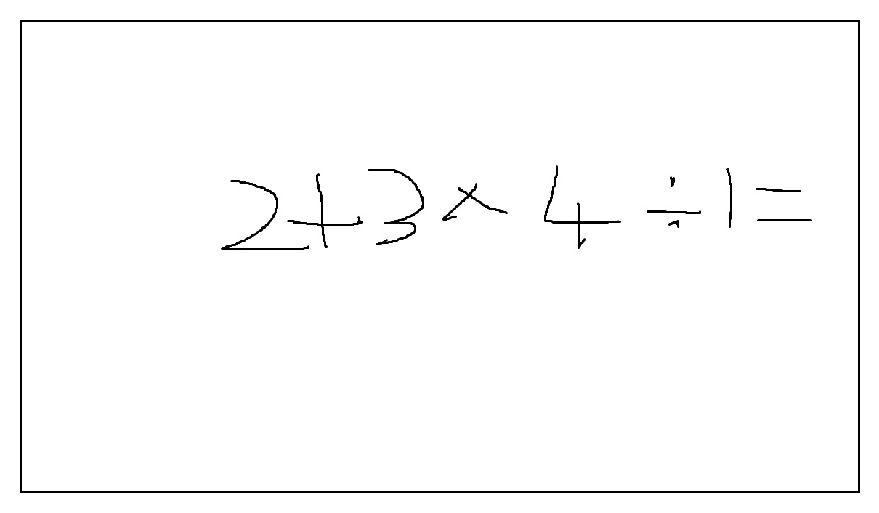

In [6]:
disp_img(img)

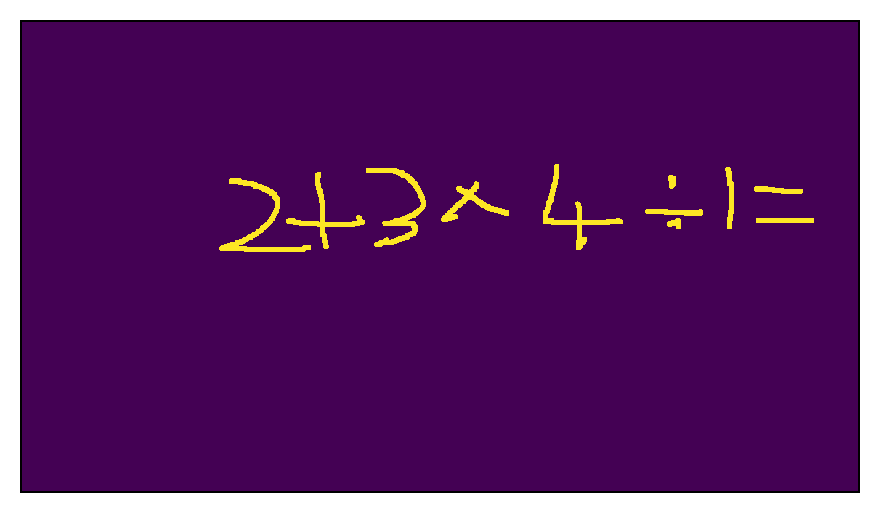

In [7]:
gray = cv.cvtColor(img.copy(), cv.COLOR_BGR2GRAY)
blurred = cv.GaussianBlur(gray, (5, 5), 10)
thresh = cv.adaptiveThreshold(blurred, 255, 0, 1, 115, 1)

disp_img(thresh)

In [8]:
kernel = np.ones((3,3),np.uint8)
dilation = cv.dilate(thresh,kernel,iterations = 0)

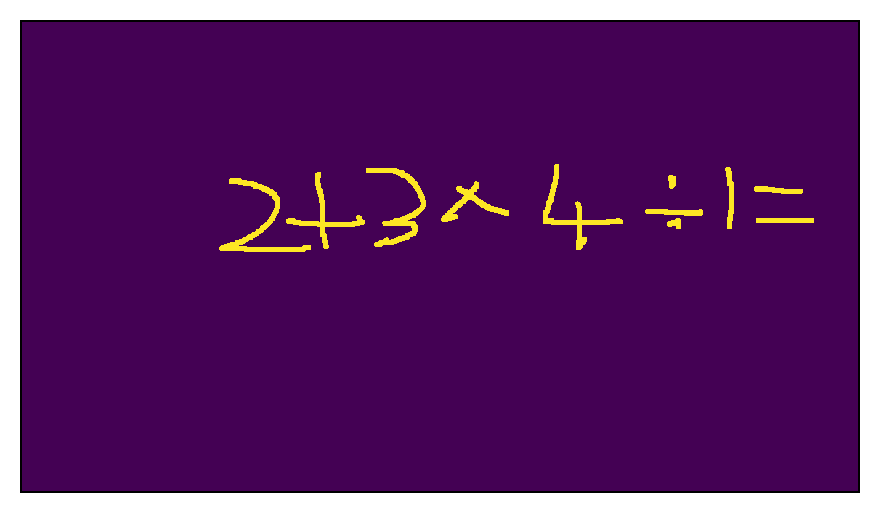

In [9]:
disp_img(dilation)

In [10]:
contours, hierarchy = cv.findContours(dilation, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda ctr: cv.boundingRect(ctr)[0])
rects = [cv.boundingRect(ctr) for ctr in contours]

In [12]:
rects

[(273, 218, 126, 101),
 (365, 209, 108, 106),
 (475, 203, 82, 109),
 (578, 222, 94, 56),
 (718, 198, 110, 119),
 (859, 260, 79, 9),
 (889, 273, 19, 15),
 (891, 213, 11, 19),
 (969, 202, 12, 86),
 (1009, 229, 67, 10),
 (1011, 272, 80, 7)]

In [13]:
new_rects = []
pad = 2
for rect in rects:
    if rect[2]/rect[3] > 5:
        temp = []
        temp.append(rect[0]-pad)
        temp.append(rect[1]-int(rect[2]))
        temp.append(rect[2]+pad)
        temp.append(rect[3]+int(2 * rect[2]))
        new_rects.append(tuple(temp))
    else:
        new_rects.append(rect)

In [14]:
new_rects

[(273, 218, 126, 101),
 (365, 209, 108, 106),
 (475, 203, 82, 109),
 (578, 222, 94, 56),
 (718, 198, 110, 119),
 (857, 181, 81, 167),
 (889, 273, 19, 15),
 (891, 213, 11, 19),
 (969, 202, 12, 86),
 (1007, 162, 69, 144),
 (1009, 192, 82, 167)]

In [15]:
def union(a,b):
    x = min(a[0], b[0])
    y = min(a[1], b[1])
    w = max(a[0]+a[2], b[0]+b[2]) - x
    h = max(a[1]+a[3], b[1]+b[3]) - y
    return (x, y, w, h)

def intersection(a,b):
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0]+a[2], b[0]+b[2]) - x
    h = min(a[1]+a[3], b[1]+b[3]) - y
    if w<0 or h<0: return () # or (0,0,0,0) ?
    return (x, y, w, h)

In [16]:
def rect_area(rect):
    try:
        return rect[2] * rect[3]
    except IndexError:
        return 0

In [17]:
from itertools import combinations
windows = list(zip(new_rects, new_rects[1:], new_rects[2:]))
final_rects = deepcopy(new_rects)
for window in windows:
    for combination in combinations(window, 2):
        combination = list(combination)
        common = intersection(combination[0], combination[1])
        area_common = rect_area(common)
        area1 = rect_area(combination[0])
        area2 = rect_area(combination[1])
        combination = sorted(combination, key=lambda x: rect_area(x), reverse=True)
        try:
            if area_common == area1 or area_common == area2:
                final_rects.remove(combination[-1])
            if area_common > area1/2 and area_common > area2/2:
                final_rects.remove(combination[-1])
        except ValueError:
            pass

In [18]:
output_img = img.copy()
extracted_rects = []
pad = 1
for (x, y, w, h) in final_rects:
    extracted_rects.append(dilation.copy()[y-pad: y + h+pad, x-pad: x + w+pad])
    rect = cv.rectangle(output_img, (x, y), (x + w, y + h), (0, 0, 255), 3)

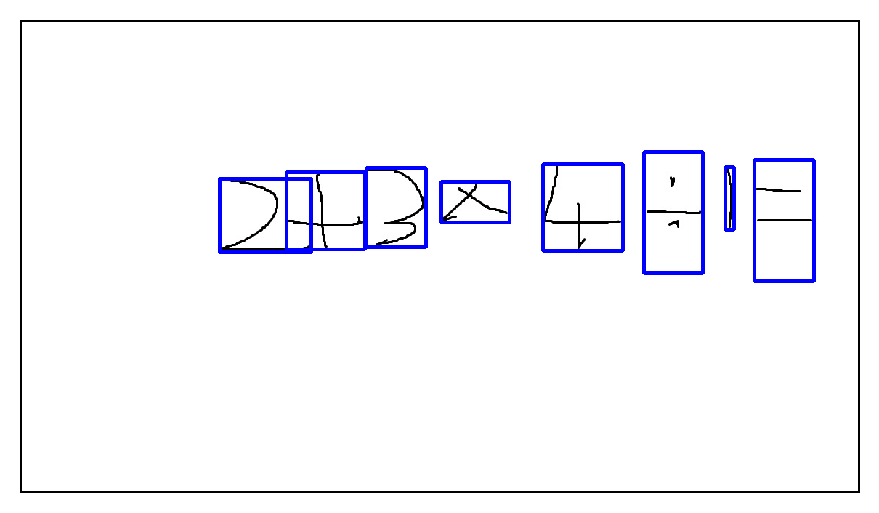

In [19]:
disp_img(output_img)

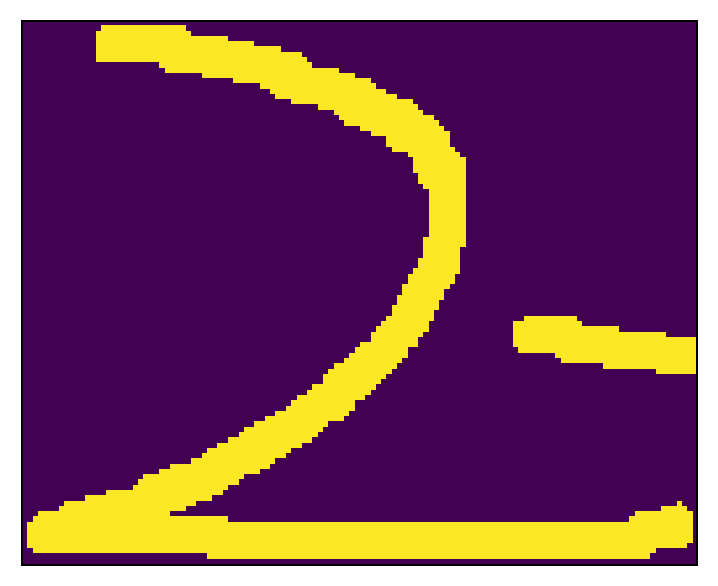

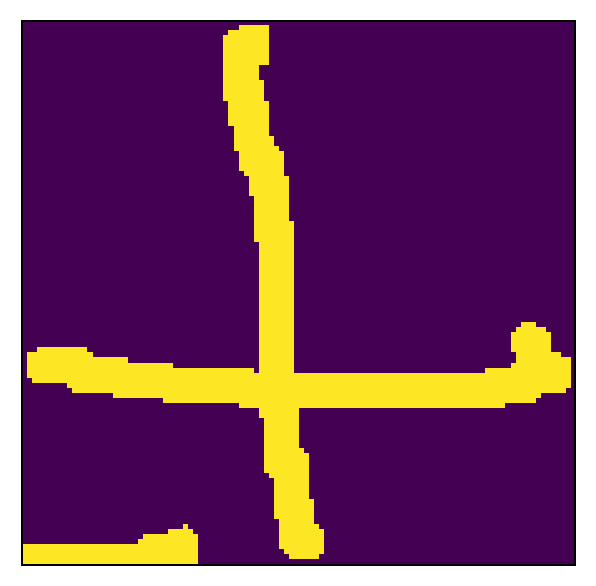

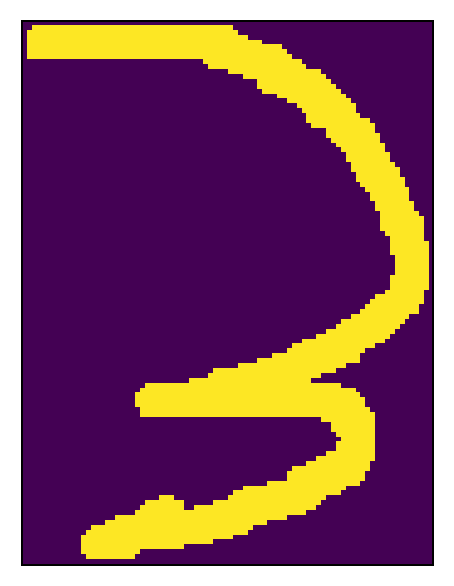

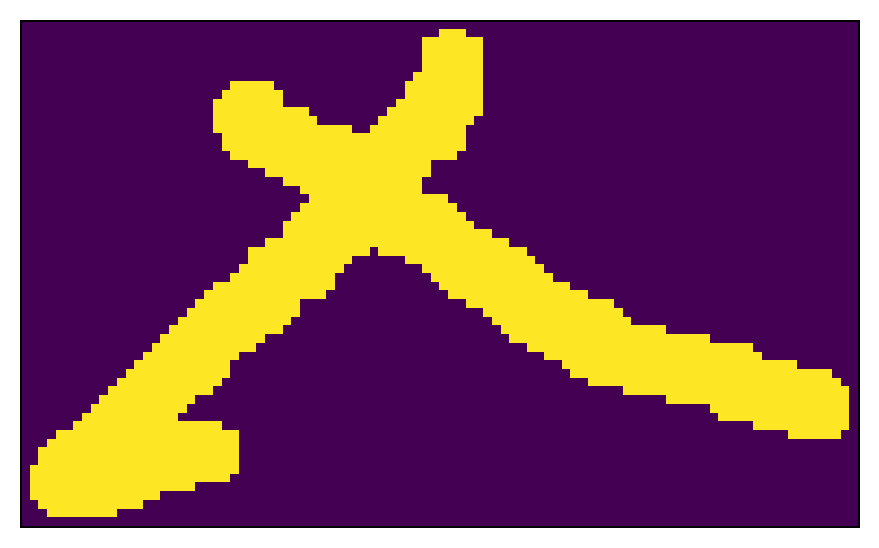

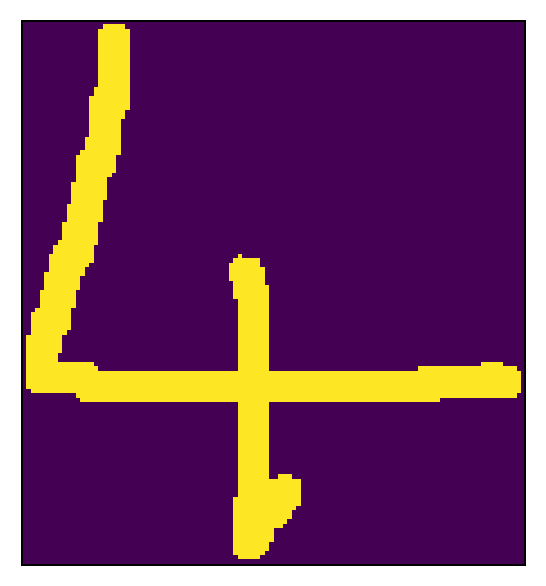

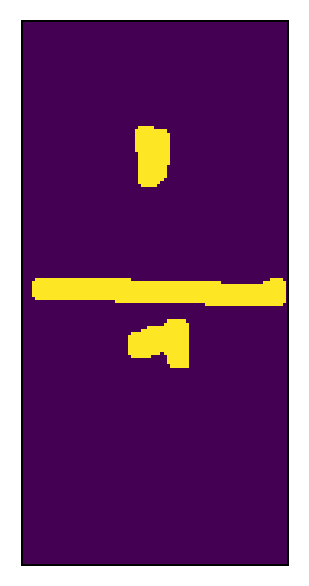

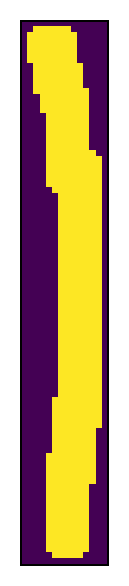

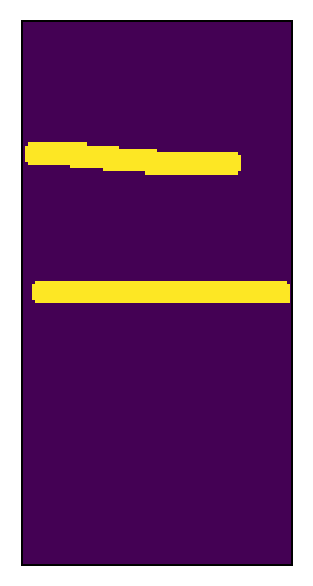

In [20]:
for i in extracted_rects:
    disp_img(i)

In [21]:
square_padded_digits = []
b_pad = 0
for i in extracted_rects:
    old_size = i.shape
    desired_size = max(i.shape)

    delta_w = desired_size - old_size[1]
    delta_h = desired_size - old_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    
    square_padded_digits.append(cv.copyMakeBorder(i, top+b_pad, bottom+b_pad, left+b_pad, right+b_pad, cv.BORDER_REPLICATE))

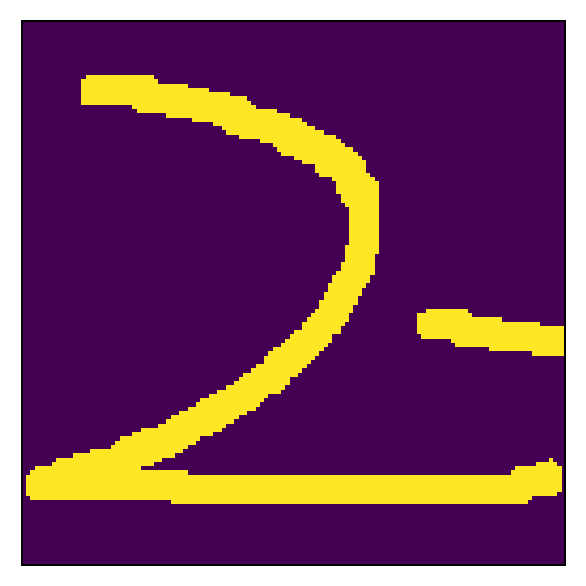

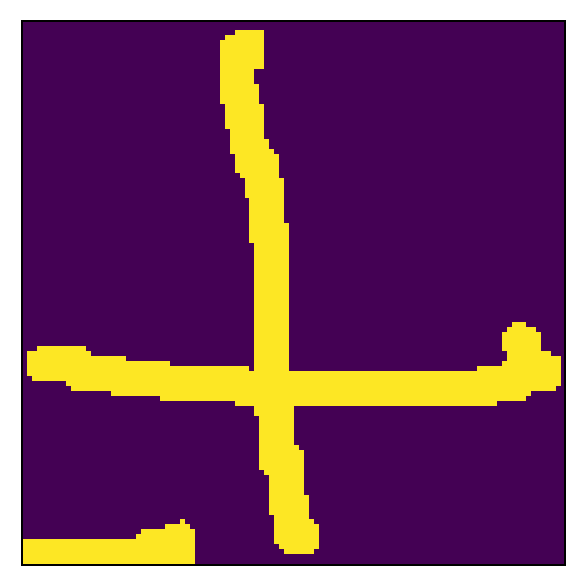

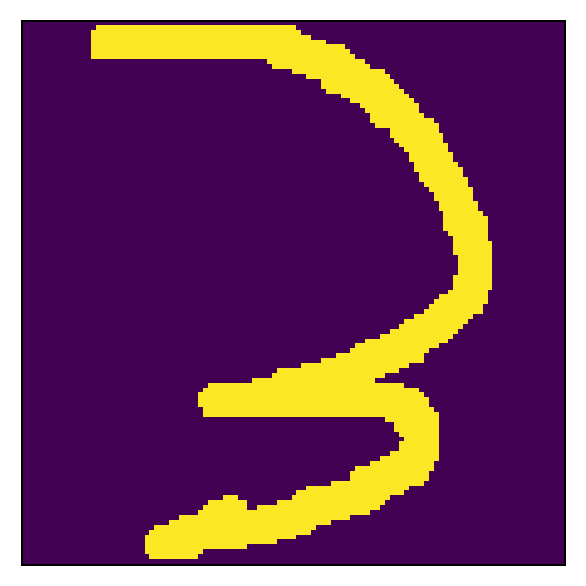

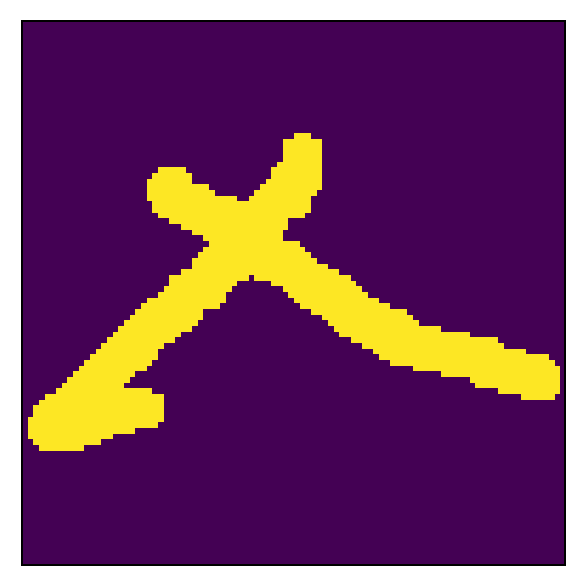

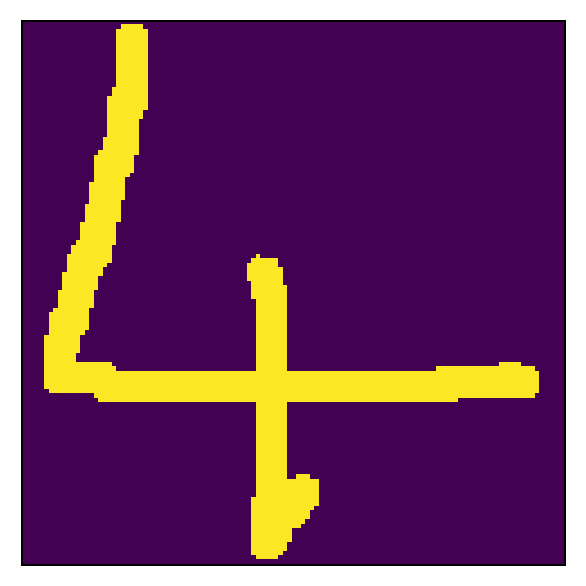

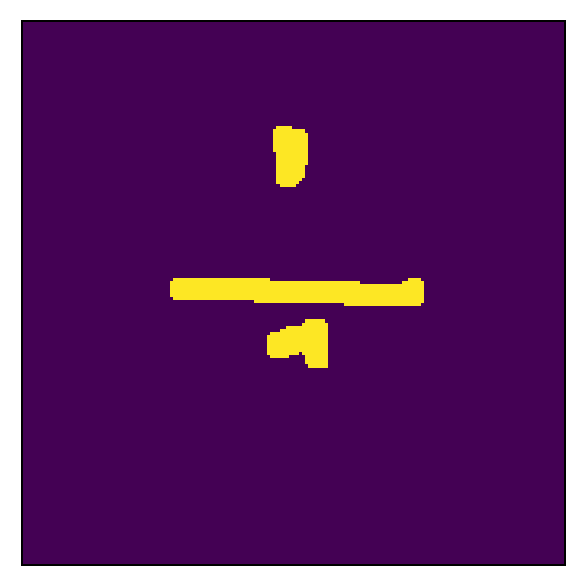

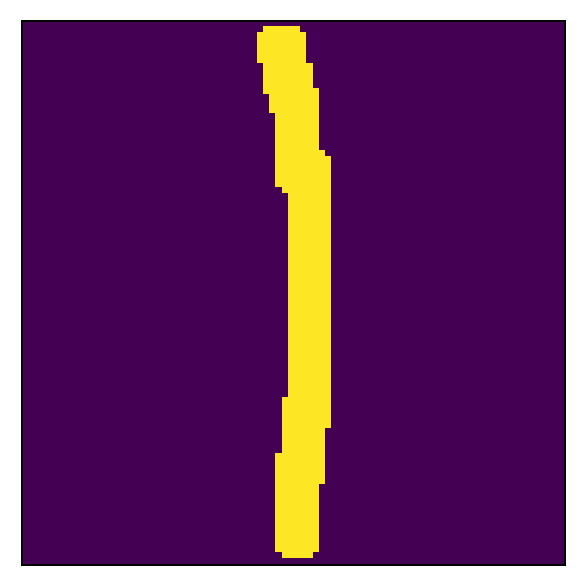

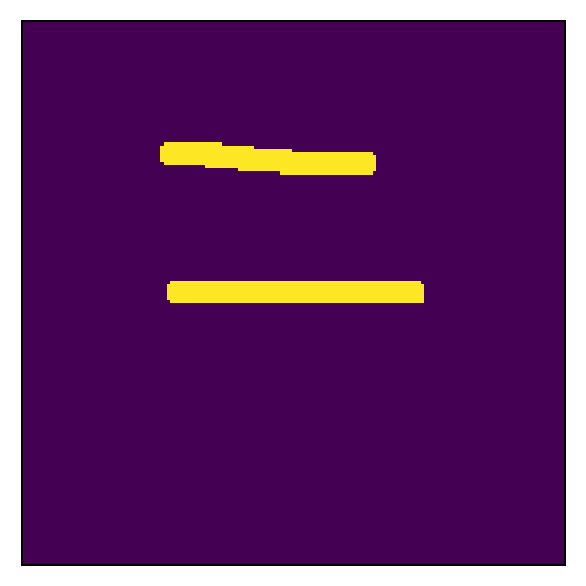

In [22]:
for i in square_padded_digits:
    disp_img(i)